<a href="https://colab.research.google.com/github/andreldeod/IDCE-302-Python-Programming/blob/main/notebooks/merging_chips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code for merging prediction chips

By André

In [12]:
%%capture
!pip install rasterio

In [19]:
import os

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.merge import merge

In [15]:
#@title Set paths

input_chips = "/workspace/predictions/run1_predictions_whole_field"
output_path = "/workspace/predictions"


In [16]:
#@title Check paths

# Check if the directory exists
if os.path.exists(input_chips):
    # List all files and directories in the workspace directory
    workspace_contents = os.listdir(input_chips)
    print(workspace_contents)
else:
    print(f"The directory {input_chips} does not exist.")

['chip_0_0_pred.tif', 'chip_0_10_pred.tif', 'chip_0_11_pred.tif', 'chip_0_12_pred.tif', 'chip_0_13_pred.tif', 'chip_0_14_pred.tif', 'chip_0_15_pred.tif', 'chip_0_16_pred.tif', 'chip_0_17_pred.tif', 'chip_0_18_pred.tif', 'chip_0_1_pred.tif', 'chip_0_20_pred.tif', 'chip_0_21_pred.tif', 'chip_0_22_pred.tif', 'chip_0_23_pred.tif', 'chip_0_24_pred.tif', 'chip_0_25_pred.tif', 'chip_0_26_pred.tif', 'chip_0_27_pred.tif', 'chip_0_28_pred.tif', 'chip_0_29_pred.tif', 'chip_0_2_pred.tif', 'chip_0_30_pred.tif', 'chip_0_31_pred.tif', 'chip_0_32_pred.tif', 'chip_0_33_pred.tif', 'chip_0_34_pred.tif', 'chip_0_35_pred.tif', 'chip_0_36_pred.tif', 'chip_0_37_pred.tif', 'chip_0_3_pred.tif', 'chip_0_40_pred.tif', 'chip_0_41_pred.tif', 'chip_0_42_pred.tif', 'chip_0_43_pred.tif', 'chip_0_44_pred.tif', 'chip_0_49_pred.tif', 'chip_0_4_pred.tif', 'chip_0_52_pred.tif', 'chip_0_54_pred.tif', 'chip_0_55_pred.tif', 'chip_0_57_pred.tif', 'chip_0_58_pred.tif', 'chip_0_59_pred.tif', 'chip_0_5_pred.tif', 'chip_0_60_pred

In [20]:
#@title Merge chips

# Prepare a list to collect the raster datasets
src_files_to_mosaic = []

# Loop through each file in the directory
for filename in os.listdir(input_chips):
    if filename.endswith('.tif'):
        filepath = os.path.join(input_chips, filename)
        # Open the raster and append to list
        src = rasterio.open(filepath)
        src_files_to_mosaic.append(src)

# Merge function
mosaic, out_trans = merge(src_files_to_mosaic, method='max')

# Copy metadata from the first source file
out_meta = src_files_to_mosaic[0].meta.copy()

# Update the metadata
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "compress": 'lzw'
})

# Output directory and file name construction
output_file_name = f"{os.path.basename(input_chips)}_merged_prediction.tif"
output_file_path = os.path.join(os.path.dirname(input_chips), output_file_name)

# Write the mosaic raster to disk
with rasterio.open(output_file_path, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"Merging complete. File saved as: {output_file_path}")

Merging complete. File saved as: /workspace/predictions/run1_predictions_whole_field_merged_prediction.tif


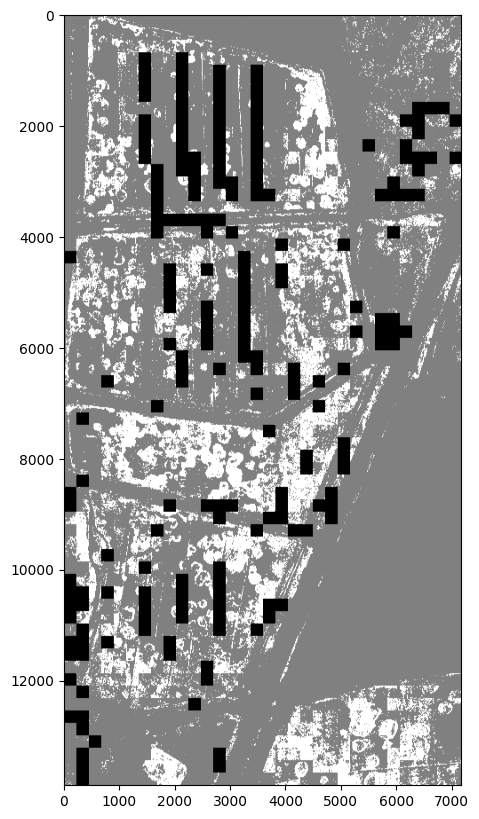

In [21]:
#@title Show chips

# Open the merged TIFF file
with rasterio.open(output_file_path) as src:
    # Read the first band
    image = src.read(1)
    # Set up the plot
    plt.figure(figsize=(10, 10))
    show(image, cmap='gray')  # Use gray color map for binary data visualization

In [36]:
#@title Chip a raster. For creating pridiction chips. Will not save nan chips

def chip_raster(input_path, output_dir, chip_size, ignore_bad_chips=True):
    # Open the input GeoTIFF
    with rasterio.open(input_path) as src:
        # Get the number of rows and columns of the input raster
        width, height = src.width, src.height
        # Calculate the number of chips in x and y directions
        num_x_chips = width // chip_size
        num_y_chips = height // chip_size

        # Loop over the grid of chips
        for i in range(num_x_chips):
            for j in range(num_y_chips):
                # Calculate the window to read
                window = Window(i * chip_size, j * chip_size, chip_size,
                                chip_size)
                # Read the window and its transform
                chip_data = src.read(window=window)
                chip_transform = src.window_transform(window)

                # If ignore_bad_chips is True, check for NaNs or zeros and
                #skip if found
                if ignore_bad_chips:
                    if np.any(np.isnan(chip_data)) or np.any(chip_data == 0):
                        continue

                # Define output path for each chip
                chip_path = os.path.join(output_dir, f'chip_{i}_{j}.tif')

                # Update metadata for the chip
                chip_meta = src.meta.copy()
                chip_meta.update({
                    'driver': 'GTiff',
                    'height': chip_size,
                    'width': chip_size,
                    'transform': chip_transform
                })

                # Write the chip
                with rasterio.open(chip_path, 'w', **chip_meta) as chip_dst:
                    chip_dst.write(chip_data)

# Parameters
input_path = '/workspace/ortho/07_0508_ortho_6band_clip.tif'
output_dir = '/workspace/chips_for_predictions'  # Where to save the chips
chip_size = 224  # Size of the chip

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Chip the raster
chip_raster(input_path, output_dir, chip_size)